In [51]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from pprint import pprint

from tiled.client import from_uri
import matplotlib.pyplot as plt
import matplotlib as mpl

In [53]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

# Basic Tutorial

The [AIMM post-processing pipeline](https://github.com/AI-multimodal/aimm-post-processing) is built around the `Operator` object. The `Operator`'s job is to take a `client`-like object and execute a post-processing operation on it. The specific type of operation is defined by the operator. All metadata/provenance is tracked.

In [54]:
from aimmdb.postprocessing import operations

Connect to the `tiled` client. This one is the [aimmdb](https://github.com/AI-multimodal/aimmdb) hosted at [aimm.lbl.gov](https://aimm.lbl.gov/api). Note that my API key is stored in an environment variable, `TILED_API_KEY`. 

In [55]:
CLIENT = from_uri("https://aimm.lbl.gov/api")

In [56]:
list(CLIENT["dataset"])

['newville']

## Unary operators

A [unary operator](https://en.wikipedia.org/wiki/Unary_operation) takes a single input. This input specifically refers to the fact that these operators only act on a single data point (meaning a `DataFrameClient`) at a time. We'll provide some examples here.

First, lets get a single `DataFrameClient` object:

In [57]:
df_client = CLIENT["uid"]["Bt5hUbgkfzR"]
type(df_client)

tiled.client.dataframe.DataFrameClient

### The identity

The simplest operation we can perform is nothing! Let's see what it does. First, feel free to print the output of the `df_client` so you can see what's contained. Using the `read()` method will allow you to access the actual data, and the `metadata` property will allow you to access the metadata:

In [58]:
_ = df_client.read()    # is a pandas.DataFrame
_ = df_client.metadata  # is a python dictionary

The identity operator is instantiated and then run on the `df_client`.

In [59]:
op = operations.Identity()
result = op(df_client)

Every result of any operator will be a dictionary with two keys: `"data"` and `"metadata"`, which correspond to the results of `read()` and `metadata` above. The data is the correspondingly modified `pandas.DataFrame` object (which in the case of the identity, is of course the same as what we started with). The metadata is custom created for a derived, post-processed object.

First, let's check that the original and "post-processed" data are the same.

In [60]:
assert (df_client.read() == result["data"]).all().all()

Next, the metadata:

In [61]:
result["metadata"]

{'_tiled': {'uid': 'cpBihwJgY6c'},
 '_post_processing': {'parents': ['Bt5hUbgkfzR'],
  'operator': {'@module': 'aimmdb.postprocessing.operations',
   '@class': 'Identity',
   '@version': None},
  'kwargs': {},
  'datetime': '2022-11-02 15:36:32 UTC'}}

First, a new unique id is assigned. Second, given this is a derived quantity, the previous original metadata is now gone in place of a `post_processing` key. This key contains every bit of information needed for provenance, including the parents (which is just one in the case of a unary operator), the operator details (including code version), any keyword arguments used during instantiation, and the datetime at which the opration was run. We use the [MSONable](https://pythonhosted.org/monty/_modules/monty/json.html) library to take care of most of this for us.

We can compare against the original metadata to see the differences.

In [62]:
df_client.metadata

{'_tiled': {'uid': 'Bt5hUbgkfzR'},
 'beamline': {'name': 'APS 13-ID-C', 'notes': 'vert slits = 0.3mm'},
 'column': {'1': 'energy eV', '2': 'i0', '3': 'itrans'},
 'comments': '#    Note: mono d_spacing is nominal!\n'
             '#     data from co_foil.002\n'
             '#     418 E XMU I0\n',
 'dataset': 'newville',
 'detector': {'I0': 'N2 10cm', 'I1': 'N2 10cm'},
 'element': {'edge': 'K', 'symbol': 'Co'},
 'extra_version': '',
 'measurement_type': 'xas',
 'mono': {'d_spacing': '3.13550',
          'name': 'Si(111)',
          'notes': 'focussed, detuned 50%'},
 'sample': {'formula': 'Co',
            'name': 'Co foil  Room Temperature',
            'prep': 'metal foil',
            'reference': 'none',
            'temperature': 'Room Temperature',
            'uid': '5YmgGEvAx2r'},
 'sample_id': '5YmgGEvAx2r',
 'scan': {'start_time': '2001-06-26 21:21:20'},
 'xdi_version': '1.0'}

### Standardizing the grids

Often times (and especially for e.g. machine learning applications) we need to interpolate our spectral data onto a common grid. We can do this easily with the `StandardizeGrid` unary operator.

In [63]:
op = operations.StandardizeGrid(x0=7550.0, xf=8900.0, nx=100, x_column="energy", y_columns=["itrans"])
result = op(df_client)

Here's a visualization of what it's done:

In [64]:
d0 = df_client.read()

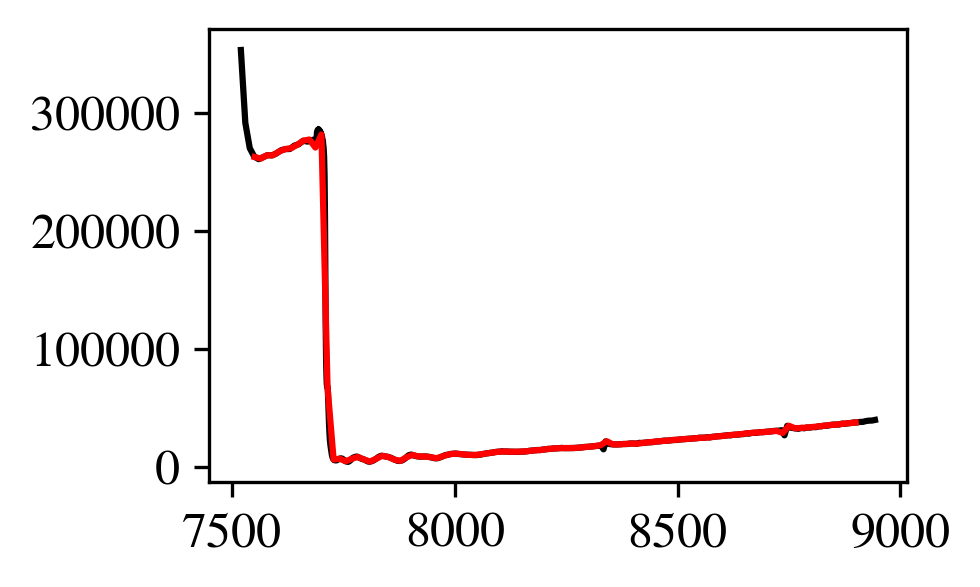

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(d0["energy"], d0["itrans"], 'k-')
ax.plot(result["data"]["energy"], result["data"]["itrans"], 'r-')
plt.show()

### Spectral postprocessing

In order to make XAS usable, we need to do a few things. Particularly:
1. Subtract off the pre-edge trend
2. Normalize the tail region to 1

We provide tools to do this systematically. For what follows, we'll do this on a Co spectrum.

In [68]:
node = CLIENT["uid"]["Bt5hUbgkfzR"]
df = node.read()

import numpy as np
df["mutrans"] = -np.log(df["itrans"]/df['i0'])

energy = df["energy"]
mutrans = df["mutrans"]

Here's what the spectrum looks like before postprocessing:

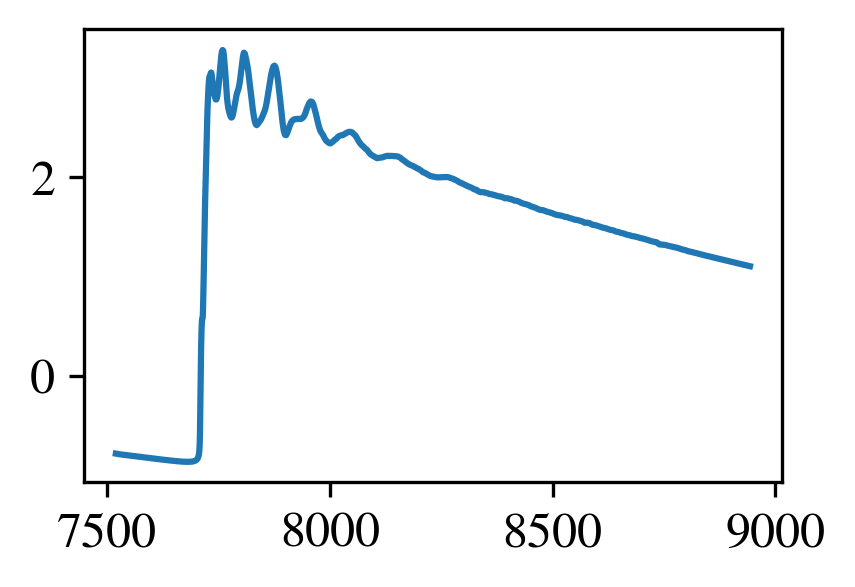

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(energy, mutrans)
plt.show()

In [70]:
remove_background = operations.RemoveBackground(x0=7510, xf=7690, y_columns=["mutrans"], victoreen_order=0)
standardize_intensity = operations.StandardizeIntensity(x0=8000, xf=None, y_columns=["mutrans"])

In [76]:
tmp_data = remove_background({'data': df, 'metadata': node.metadata})
new_data = standardize_intensity(tmp_data)

In [77]:
new_df = new_data["data"]
energy = new_df["energy"]
mutrans = new_df["mutrans"]

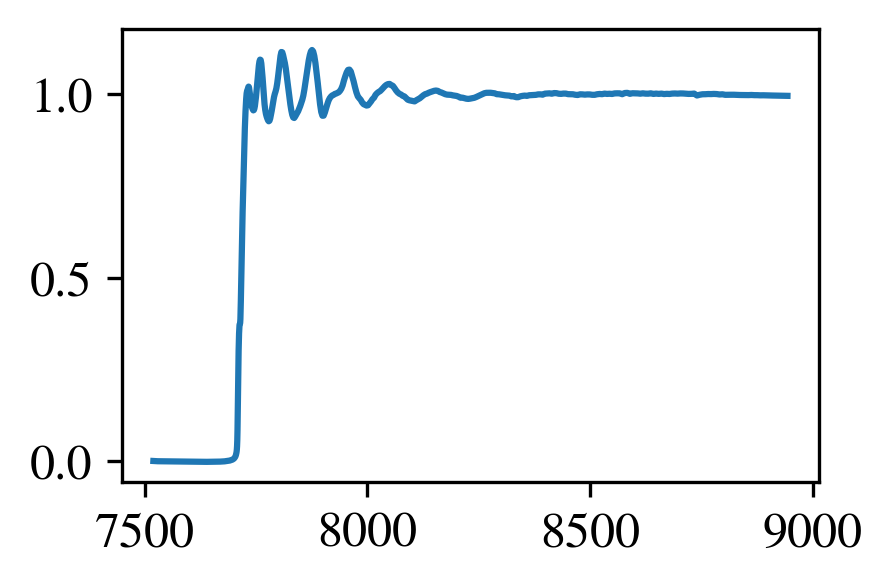

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(energy, mutrans)
plt.show()

Alternative normalization scheme using x-ray larch (see: https://xraypy.github.io/xraylarch/)

dict_keys(['energy', 'mutrans'])


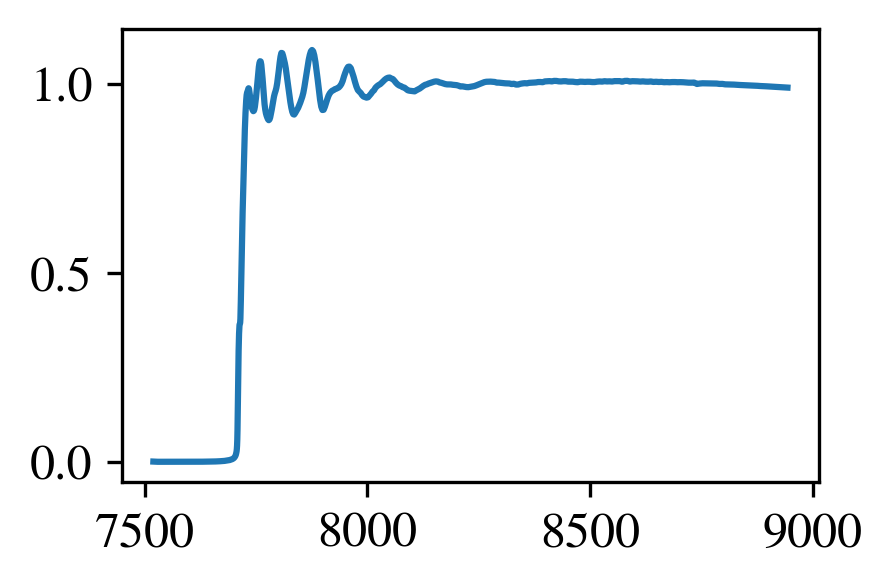

In [86]:
normalize_xas = operations.NormalizeLarch(y_columns=["mutrans"])
larch_norm_data = normalize_xas(tmp_data)

larch_norm_df = larch_norm_data["data"]
energy = larch_norm_df["energy"]
mutrans = larch_norm_df["mutrans"]

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(energy, mutrans)
plt.show()